# Training a Convolutional Neural Network For Spot Detection Using Simulations. 

## Applied to empirical confocal flurescent microscopy images

Date: _1/15/2020_

**abstract**: Spot detection is an important task in many fields such as Biology, Astronomy, and Physics. Unfortunately, the task of counting spots in images can take experts many laborious hours to do by hand. Recent studies (cite) have shown that Machine Learning has potential to automate this task. However, It remains a problem to acquire pixel-level annotations needed as targets for any type of supervised learning.  Here, we present a novel method of training convolutional neural networks on simulated images --- allowing users to completely side-step the need for human annotated data sets. Our results exemplify that this method offers a competitive F1 score on empirical, fluorescent microscopy images when compared to other supervised machine learning methods.

This Jupyter Notebook will exemplify the workflow for simulating 
a dataset of spots with thier respective annotations - then train a neural network to parse out dots from background noise. Finally, we will import an empirical flurescent microscopy image and Predict on The image before computing the F1 score as a metric of accuracy. This Workflow is proof of concepy that spots can be simulted easily and accuratly enough to train a convolutional nueral network on the task of spot detection.

In [3]:
import os
import sys

# External Dependencies
import numpy as np
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from matplotlib import pyplot as plt
%matplotlib inline
import time

# Internal Dependencies 
sys.path.insert(0,"../")
import scripts.networks as nets
import scripts.helpers as helpers
import scripts.dot_simulator as dot_simulator

In [4]:
help(dot_simulator.single_layers_simulator)

Help on function single_layers_simulator in module scripts.dot_simulator:

single_layers_simulator(num_samples=10, width=32, height=32, num_dots_n=5, num_dots_p=0.5, radii_n=3, radii_p=0.85, spot_noise=0.2, point_noise=0.2, background_noise=0.2)
    This function will generate single layer 
    samples of simulated flurescent microscopy images
    along with the respective ground truth annotation. 
    The simulations themselves are defined by:
    
    :param: width, height <int> - The width and height of the simulated images
        defined in number of pixels.
    
    :param: coloc_thresh <int> - This is a number, either 1, 2, or 3 which 
        which primarily affects how we annotate the images as being true positives
        or negative examples. Concretely, this is the threshold of number of layers
        which any dot must colocalize in order to be considered as a synapse.
    
    :param: num_dots_n, num_dots_p <int> - these parameters define the expected 
        binomial d

In [5]:
# The directory to place output files and location of test files
# this directory should contain the empirical test image and it's annotations.
EXP_DIR = "../scripts/L1-D02-z_490_448_64"

## Simulation Parameters

The real trick to using simulation for training a neural network is to choose parameters which reflect your data. Here, we allow you to choose the size of your simulated image, the distribution of number of dots per image, the distribution of radii for all dots, and noise. All parameters are described in more detail above.

In [10]:
# Choose Some parameters
params = {"num_samples":1000,
            "width":64,
            "height":64,
            "num_dots_n": 5,
            "num_dots_p": 0.85,
            "radii_n":5,
            "radii_p":0.65,
            "spot_noise":0.2,
            "point_noise":0.2,
            "background_noise":0.15}

To see how the parameters we chose will impact the number and size of spots in out simualtions, we can look at a binomial distribution 

Text(0.5, 1.0, 'Exp Size of radii across Spots')

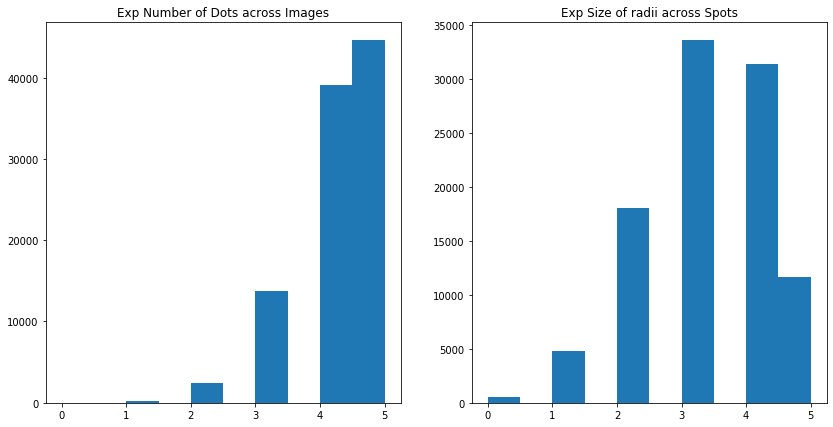

In [11]:
dots = np.random.binomial(n = params["num_dots_n"], p = params["num_dots_p"], size = 100000)
radii = np.random.binomial(n = params["radii_n"], p = params["radii_p"], size = 100000)
fig, ax = plt.subplots(1,2, figsize=(14, 7))
ax[0].hist(dots)
ax[0].set_title("Exp Number of Dots across Images")
ax[1].hist(radii)
ax[1].set_title("Exp Size of radii across Spots")

### Let's do the simulations!

Simulating is extremely simple.

In [12]:
start_sim = time.time()
x, y = dot_simulator.single_layers_simulator(**params)
finish_sim = time.time()

num_sims = params["num_samples"]
print(f"{num_sims} simulations took {round(finish_sim - start_sim,2)} seconds to finish")
print(f"simulated data examples has shape: {x.shape}")
print(f"simulated data set targets has shape: {y.shape}")

1000 simulations took 2.83 seconds to finish
simulated data examples has shape: (1000, 64, 64, 1)
simulated data set targets has shape: (1000, 64, 64, 1)


### What do they look like?

Here we can plot our simulations to get a rough idea about how close we are simulating an empirical image ...

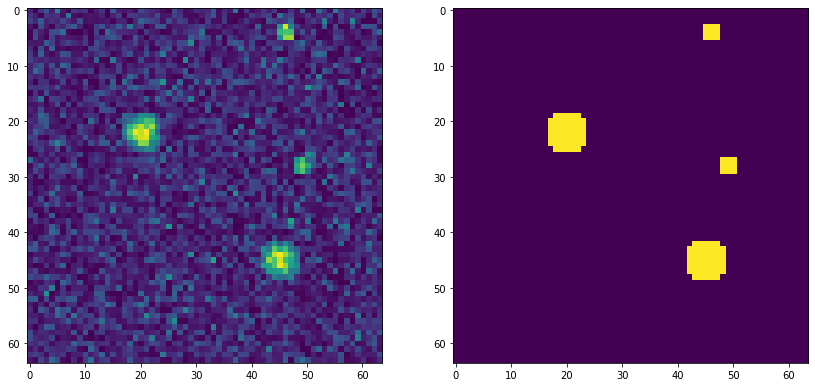

In [14]:
IMAGE_INDEX = 10
fig, ax = plt.subplots(1,2,figsize=(14, 11))
ax[0].imshow(np.squeeze(x[IMAGE_INDEX]))
ax[1].imshow(np.squeeze(y[IMAGE_INDEX]))

### Deep Learning

We will now prep our data by splitting it into test, validation, and training. Shuffling the Data is unneccesary because the samples and annotations (targets) are all independent 

In [15]:
percent_test = 0.1
percent_validation = 0.2

test_split = int(x.shape[0] * percent_test) 
vali_split = int(x.shape[0] * percent_validation)

test_x = x[:test_split,:,:,:]
vali_x = x[test_split:vali_split,:,:,:]
train_x = x[vali_split:,:,:,:]

test_y = y[:test_split,:,:,:]
vali_y = y[test_split:vali_split,:,:,:]
train_y = y[vali_split:,:,:,:]

### choose a model!

Our model has the following simple architecture. We use binary crossentropy as out loss function.

In [16]:
model = nets.deeper_direct_CNN(x,y)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 1)         289       
Total params: 19,393
Trainable params: 19,393
Non-trainable params: 0
_________________________________________________________________
None


### Fit the model with our simulated data!

In [42]:
history = model.fit(train_x, train_y, 
        validation_data = (vali_x, vali_y),
        epochs = 30)

Train on 800 samples, validate on 100 samples
Epoch 1/30
800/800 [==============================] - 1s 915us/step - loss: 0.1125 - acc: 0.9987 - val_loss: 0.1060 - val_acc: 0.9988
Epoch 2/30
800/800 [==============================] - 1s 758us/step - loss: 0.1112 - acc: 0.9987 - val_loss: 0.1071 - val_acc: 0.9989
Epoch 3/30
800/800 [==============================] - 1s 754us/step - loss: 0.1101 - acc: 0.9988 - val_loss: 0.1026 - val_acc: 0.9988
Epoch 4/30
800/800 [==============================] - 1s 755us/step - loss: 0.1074 - acc: 0.9988 - val_loss: 0.1010 - val_acc: 0.9988
Epoch 5/30
800/800 [==============================] - 1s 754us/step - loss: 0.1059 - acc: 0.9988 - val_loss: 0.1002 - val_acc: 0.9988
Epoch 6/30
800/800 [==============================] - 1s 753us/step - loss: 0.1048 - acc: 0.9988 - val_loss: 0.0995 - val_acc: 0.9988
Epoch 7/30
800/800 [==============================] - 1s 752us/step - loss: 0.1029 - acc: 0.9988 - val_loss: 0.0966 - val_acc: 0.9989
Epoch 8/30
800/8

### Model loss/validation as a function of epochs

The proximity of loss and validation loss gives us confidence there is no 

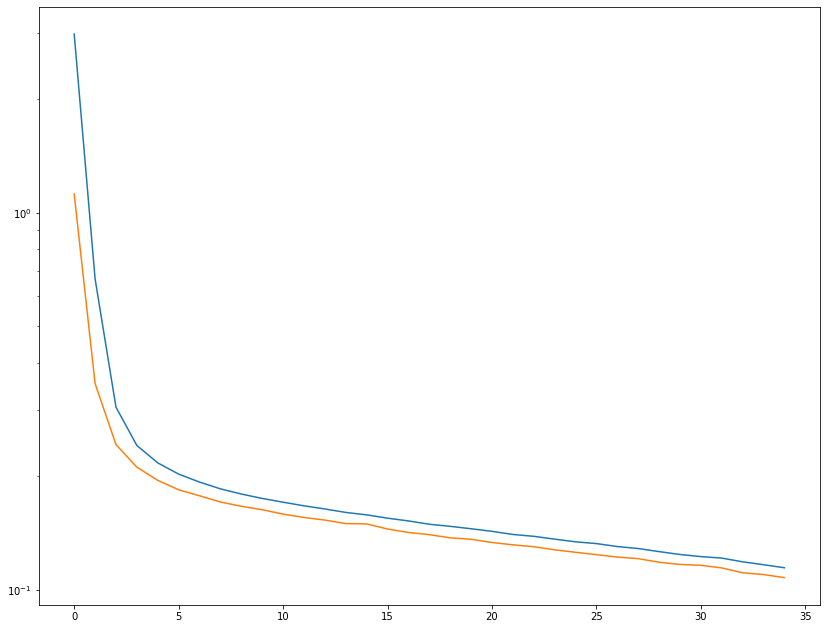

In [19]:
fig, ax = plt.subplots(1, figsize = (14,11))
ax.plot(history.history["loss"])
ax.plot(history.history["val_loss"])
ax.set_yscale("log")

### Load an empirical image for testing!

Text(0.5, 1.0, 'Human Annotation')

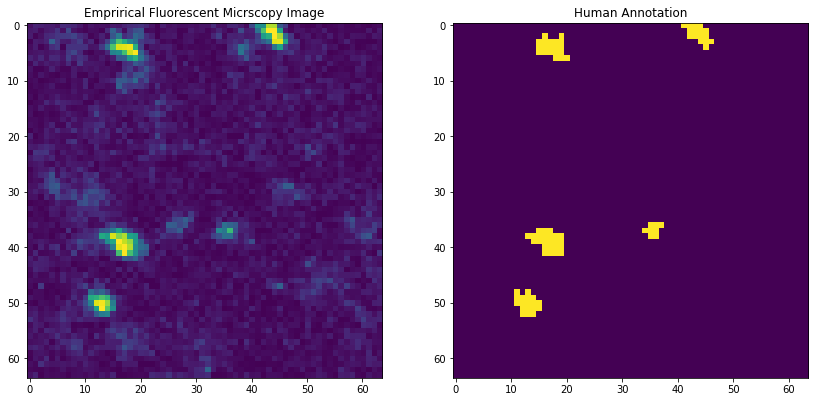

In [29]:
test_emp_image = np.load(f"{EXP_DIR}/{EXP_DIR[11:]}_image_scaled.out", allow_pickle = True)
test_emp_annotation = np.load(f"{EXP_DIR}/{EXP_DIR[11:]}_annotated.out", allow_pickle = True)
test_emp_image = np.reshape(test_emp_image,(1,64,64,1))
fig, ax = plt.subplots(1,2, figsize=(14, 13))
ax[0].imshow(np.squeeze(test_emp_image))
ax[0].set_title("Emprirical Fluorescent Micrscopy Image")
ax[1].imshow(np.squeeze(test_emp_annotation))
ax[1].set_title("Human Annotation")

### Now, let's use our model trained on simulations to predict on the real thing!

In [30]:
pred_emp = model.predict(test_emp_image)
pred_sim = model.predict(test_x)

### Lets take a look!

Text(0.5, 1.0, 'Predicted Probability Map')

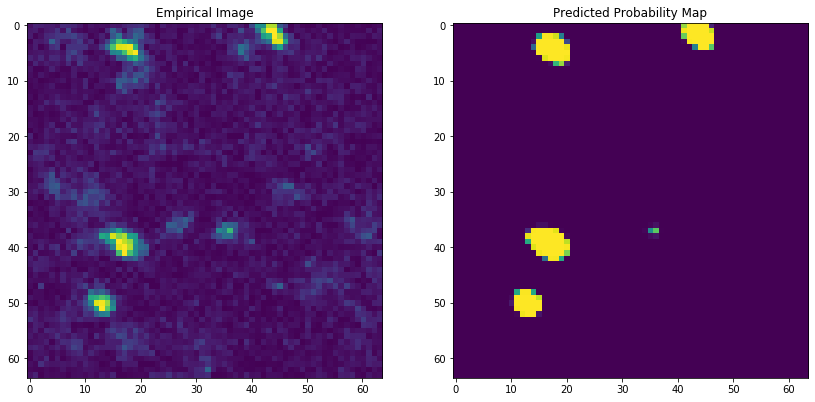

In [31]:
fig, ax = plt.subplots(1,2, figsize=(14, 13))
ax[0].imshow(np.squeeze(test_emp_image))
ax[0].set_title("Empirical Image")
ax[1].imshow(np.squeeze(pred_emp))
ax[1].set_title("Predicted Probability Map")

### Compute F1 score.

Now that we have a prediction, we can load the annotation.

In [41]:
print(f" F1 score = {round(helpers.f1_score_pixel_v_prob(np.squeeze(pred_emp), np.squeeze(test_emp_annotation)),4)}")

 F1 score = 0.8021
